# 주요 질병 사망자 및 보건 환경 비교 분석
## - 4 - 의약품 판매/소비
(Comparative Analysis of Major Disease Deaths and Health Environment)
## 1. 소개
국가별 의료 관련 데이터들을 이용해, 국가별, 연간 질병 사망자 수와 의료 인프라 간의 관계를 분석해보고 시각화를 해본 프로젝트

## 2. 목표
- 각 데이터의 EDA와 시각화
- 비슷한 분류의 데이터를 하나로 합치기
- 의료 인프라와 질병 사망자 수 관계 찾기 및 분석

## 3. 데이터 셋
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&conn_path=I2)
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC01&conn_path=I2)
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC09&conn_path=I2)
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC14&conn_path=I2)
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC25&conn_path=I2)
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC24&conn_path=I2)
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAD21&conn_path=I2)
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json)

## 4. 구현

#### 라이브러리

In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cufflinks as cf
import folium
from folium.plugins import MarkerCluster
import json

#### 한글 폰트 설정

In [4]:
from IPython.display import set_matplotlib_formats

def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

get_font_family()

plt.style.use("ggplot")

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)

set_matplotlib_formats("retina")

/var/folders/10/7lbx9bn51jl5zt97l3h72p6c0000gn/T/ipykernel_8040/2328754805.py:32: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [5]:
# 모든 데이터 공통 국가
country_intersection = ['룩셈부르크',  '네덜란드',  '영국',  '이탈리아',  '캐나다',  '오스트레일리아',  '한국',  '일본',  '스페인',  '헝가리',  '독일',  '에스토니아',  '그리스',  '슬로바키아',  '핀란드',  '벨기에',  '체코',  '슬로베니아',  '프랑스',  '스웨덴',  '노르웨이',  '뉴질랜드',  '라트비아',  '덴마크',  '오스트리아',  '포르투갈',  '아일랜드',  '아이슬란드']

### 4. 의약품 판매/소비

#### Data Load

In [6]:
# 의약품 판매, 소비 
'''
- 의약품 판매액 (1998~2020) : 'df_sale'
- 의약품 소비량 (1998~2020) : 'df_consume'
'''
df_sale = pd.read_csv('data/medi_sale.csv', encoding ="cp949" )
df_consume = pd.read_csv('data/medi_consume.csv', encoding ="cp949" )

##### 기본정보 확인

In [7]:
print('df_sale'+ ':' + str(df_sale.shape),"df_consume" +":" + str(df_consume.shape))

df_sale:(699, 3) df_consume:(6869, 4)


In [8]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   국가      699 non-null    object 
 1   시점      699 non-null    int64  
 2   데이터     584 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 16.5+ KB


In [9]:
df_consume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6869 entries, 0 to 6868
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   국가      6869 non-null   object 
 1   시점      6869 non-null   int64  
 2   의약품     6869 non-null   object 
 3   데이터     5351 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 214.8+ KB


##### 결측치

In [10]:
# df_sale 결측치 확인
df_sale.isnull().sum()

국가       0
시점       0
데이터    115
dtype: int64

In [11]:
#df_consume 결측치 확인
df_consume.isnull().sum()

국가        0
시점        0
의약품       0
데이터    1518
dtype: int64

##### 중복값

In [12]:
# df_sale 중복값 확인
df_sale.duplicated

<bound method DataFrame.duplicated of        국가    시점     데이터
0     아시아  1998     NaN
1     아시아  1999     NaN
2     아시아  2000     NaN
3     아시아  2001     NaN
4     아시아  2002     NaN
..    ...   ...     ...
694  뉴질랜드  2016   746.3
695  뉴질랜드  2017   896.8
696  뉴질랜드  2018   914.1
697  뉴질랜드  2019   983.0
698  뉴질랜드  2020  1071.3

[699 rows x 3 columns]>

In [13]:
# df_consume 중복값 확인
df_consume.duplicated

<bound method DataFrame.duplicated of         국가    시점             의약품    데이터
0      아시아  1998      소화관 및 신진대사    NaN
1      아시아  1998             제산제    NaN
2      아시아  1998  소화성궤양 및 위장용 약물    NaN
3      아시아  1998           당뇨 약물    NaN
4      아시아  1998          심장 배당체    NaN
...    ...   ...             ...    ...
6864  뉴질랜드  2014  소화성궤양 및 위장용 약물  102.0
6865  뉴질랜드  2014          심장 배당체    2.4
6866  뉴질랜드  2014          항 부정맥제    1.6
6867  뉴질랜드  2014       수면제 및 진정제   17.8
6868  뉴질랜드  2014            항우울제   72.8

[6869 rows x 4 columns]>

##### 필요없는 데이터 버리기

필요 없는 행 삭제 : 위 행은 국가의 종합된 내용으로 삭제하였습니다.
- df_sale
국가 = 아시아, 북아메리카, 남아메리카, 유럽, 오세아니아

- df_consume
국가 = 아시아,북아메리카,남아메리카,유럽,아프리카,오세아니아

In [14]:
# df_sale 행 삭제
remove_list = df_sale[df_sale["국가"].str.contains("아시아|북아메리카|남아메리카|유럽|오세아니아")].index
df_sale.drop(remove_list, inplace=True)
df_sale

국가    시점      데이터
23     한국  2008  15821.1
24     한국  2009  14736.8
25     한국  2010  17573.3
26     한국  2011  19900.7
27     한국  2012  19289.9
..    ...   ...      ...
694  뉴질랜드  2016    746.3
695  뉴질랜드  2017    896.8
696  뉴질랜드  2018    914.1
697  뉴질랜드  2019    983.0
698  뉴질랜드  2020   1071.3

[584 rows x 3 columns]

In [15]:
# df_consume 행 삭제
remove_list2 = df_consume[df_consume["국가"].str.contains("아시아|북아메리카|남아메리카|유럽|아프리카|오세아니아")].index
df_consume.drop(remove_list2, inplace=True)
df_consume

국가    시점             의약품    데이터
253     한국  2008      소화관 및 신진대사  263.6
254     한국  2008             제산제    2.2
255     한국  2008  소화성궤양 및 위장용 약물   33.1
256     한국  2008           당뇨 약물   59.8
257     한국  2008          심장 배당체    1.5
...    ...   ...             ...    ...
6864  뉴질랜드  2014  소화성궤양 및 위장용 약물  102.0
6865  뉴질랜드  2014          심장 배당체    2.4
6866  뉴질랜드  2014          항 부정맥제    1.6
6867  뉴질랜드  2014       수면제 및 진정제   17.8
6868  뉴질랜드  2014            항우울제   72.8

[5351 rows x 4 columns]

컬럼명 변경
- df_consume과 df_sale의 시점을 연도로 변경
- df_consume의 데이터를 의약품판매량으로 변경
- df_sale의 데이터를 의약품사용량으로 변경

In [16]:
# 컬럼명 변경
df_consume = df_consume.rename(columns={'시점':'연도'})
df_consume = df_consume.rename(columns={'데이터':'의약품소비량'})

df_sale = df_sale.rename(columns={'시점' : '연도'})
df_sale = df_sale.rename(columns={'데이터' : '의약품판매량'})

데이터 합치기

In [39]:
df = pd.merge(df_consume, df_sale)

데이터 파일 저장

In [40]:
file_name = 'medicion.csv'
df.to_csv(file_name, index=False)
pd.read_csv(file_name)

#### EDA 및 시각화

<AxesSubplot:xlabel='연도', ylabel='의약품판매량'>

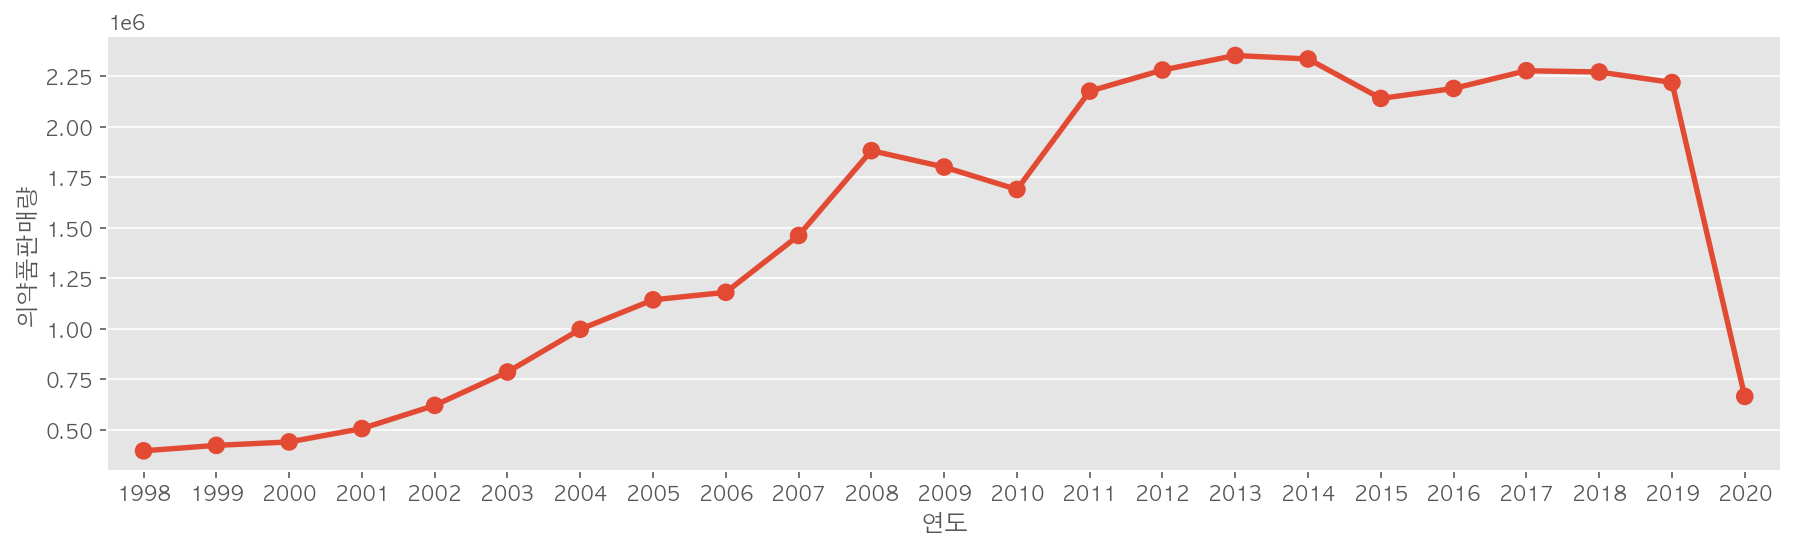

In [30]:
# 연간 의약품 판매량
plt.figure(figsize=(15,4))
sns.pointplot(data=df, x='연도', y='의약품판매량', ci=None, estimator=np.sum)

<AxesSubplot:xlabel='연도', ylabel='의약품소비량'>

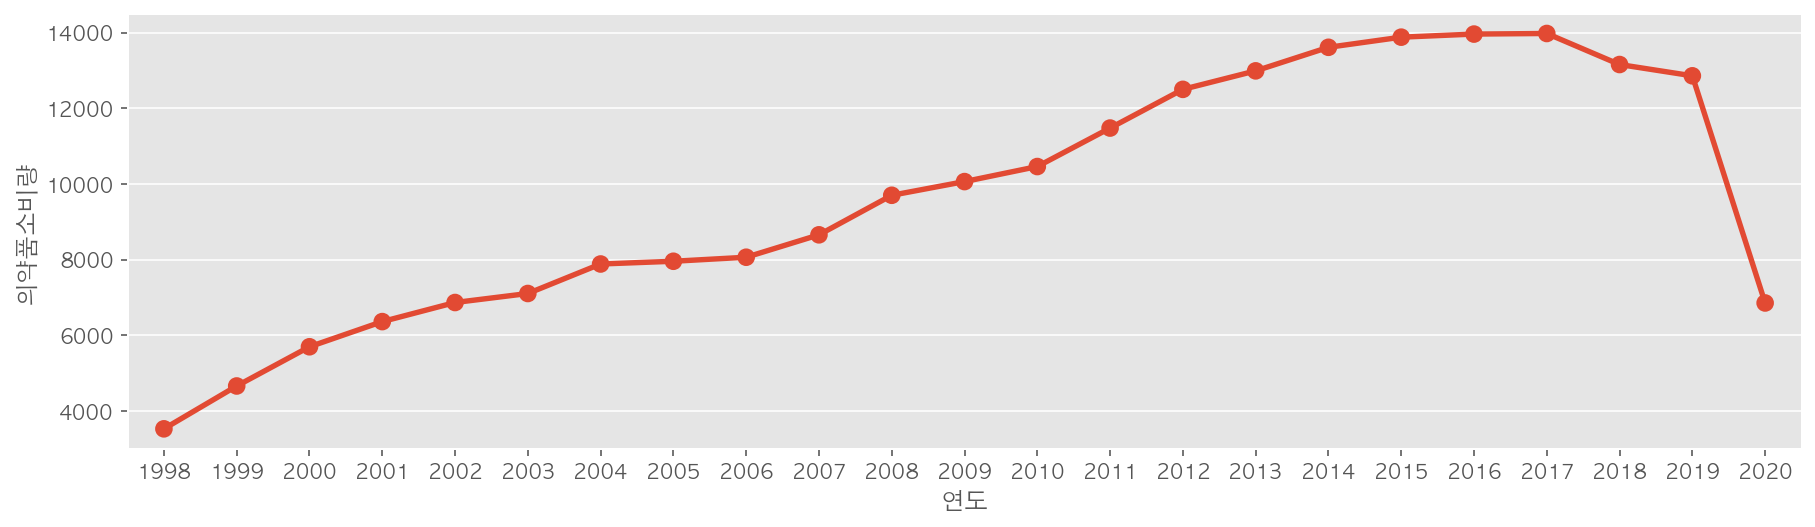

In [31]:
# 연간 의약품 소비량
plt.figure(figsize=(15,4))
sns.pointplot(data=df, x='연도', y='의약품소비량', ci=None, estimator=np.sum)

의약품 판매량과 소비량 모두 2020년에 급격하게 감소한 것을 볼 수 있습니다.

<AxesSubplot:xlabel='연도', ylabel='의약품소비량'>

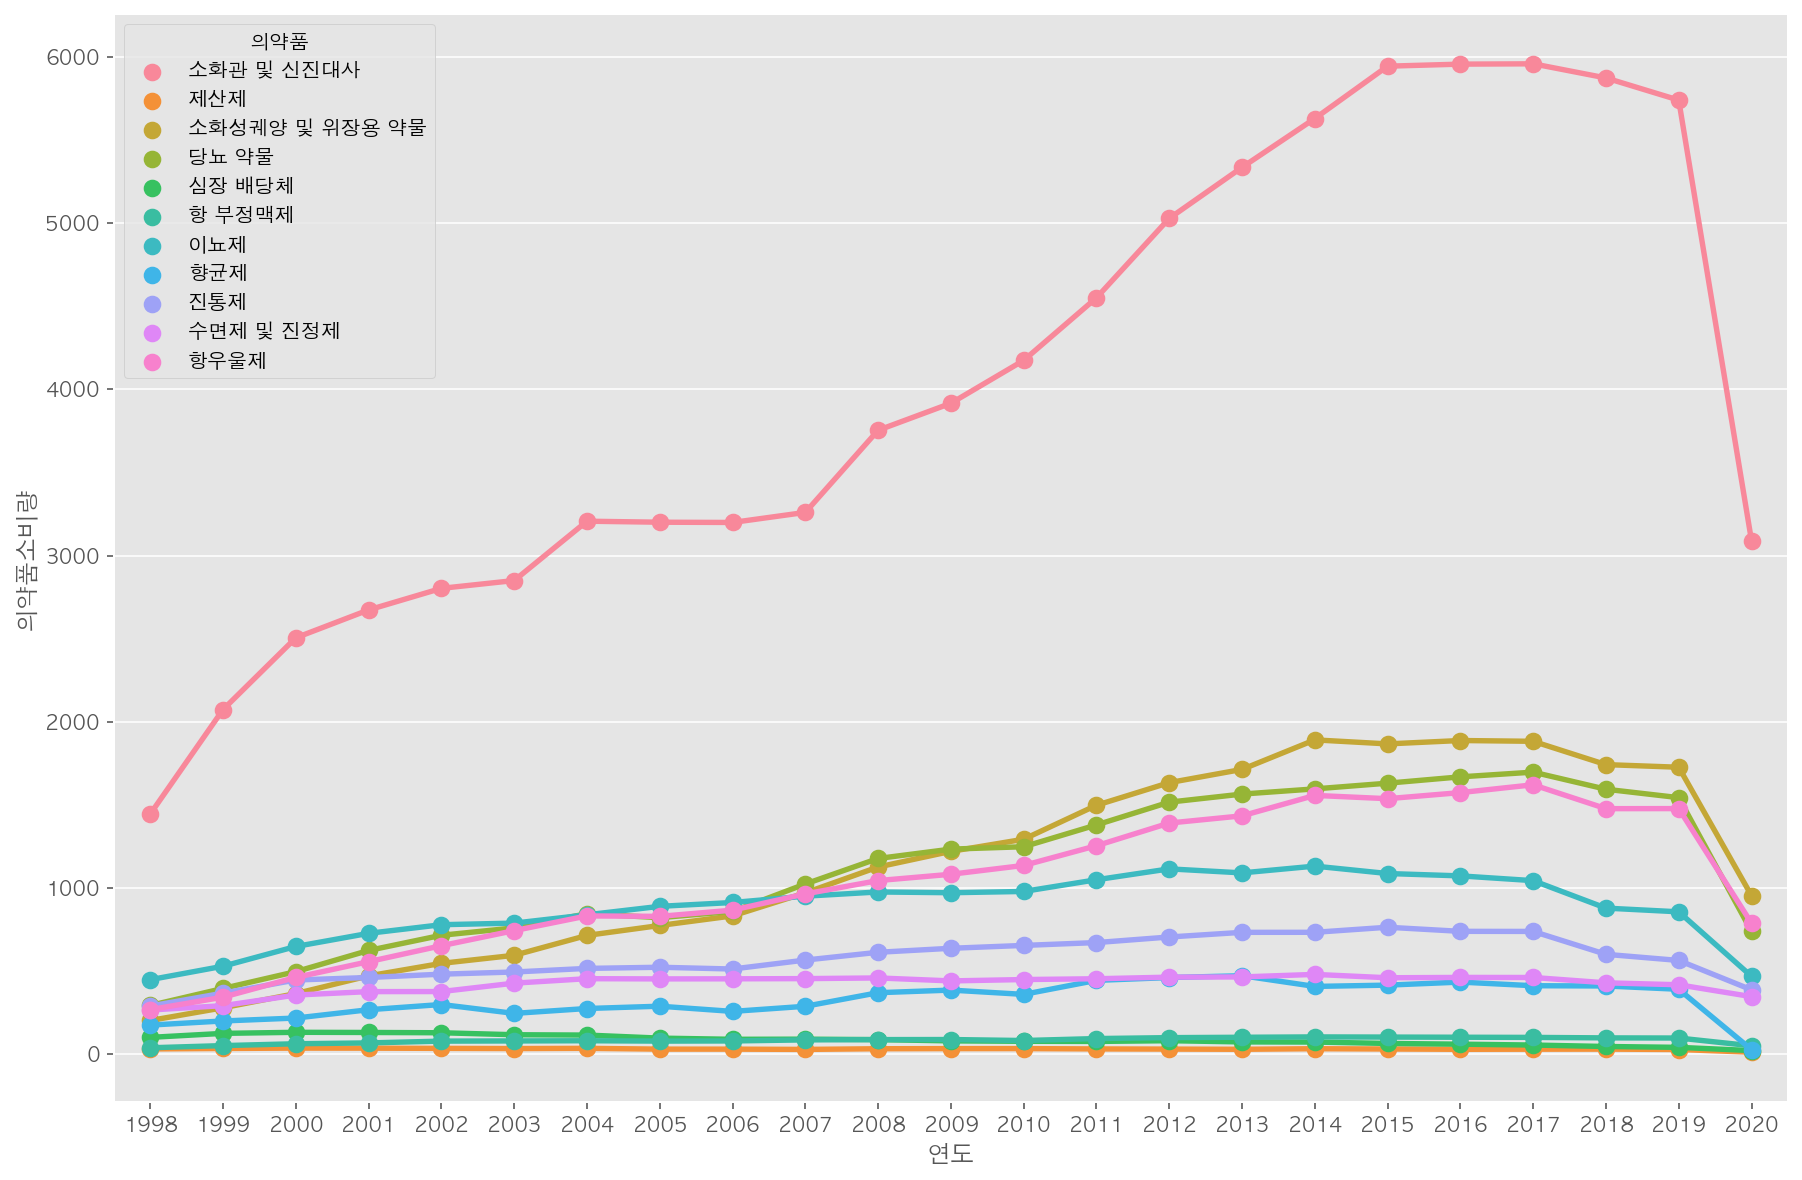

In [32]:
# 의약품에 따른 연간 의약품 소비량
plt.figure(figsize=(15,10))
sns.pointplot(data=df, x='연도', y='의약품소비량', hue='의약품', ci=None, estimator=np.sum)

소화 및 신진대사와 관련 있는 의약품의 판매량이 가장 높으나 2020년을 기점으로 전반적인 의약품의 소비량이 감소하였습니다.

<Figure size 1080x1080 with 0 Axes>

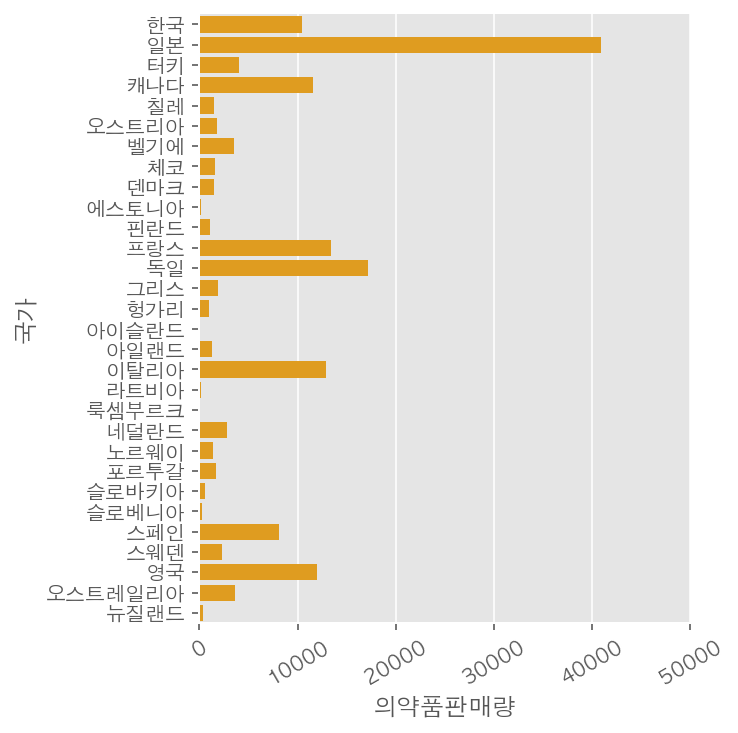

In [33]:
# 국가별 의약품 판매량
plt.figure(figsize=(15, 15))

sns.catplot(data=df, x='의약품판매량', y='국가', kind='bar', ci=None, color="Orange").set_xticklabels(rotation=30)

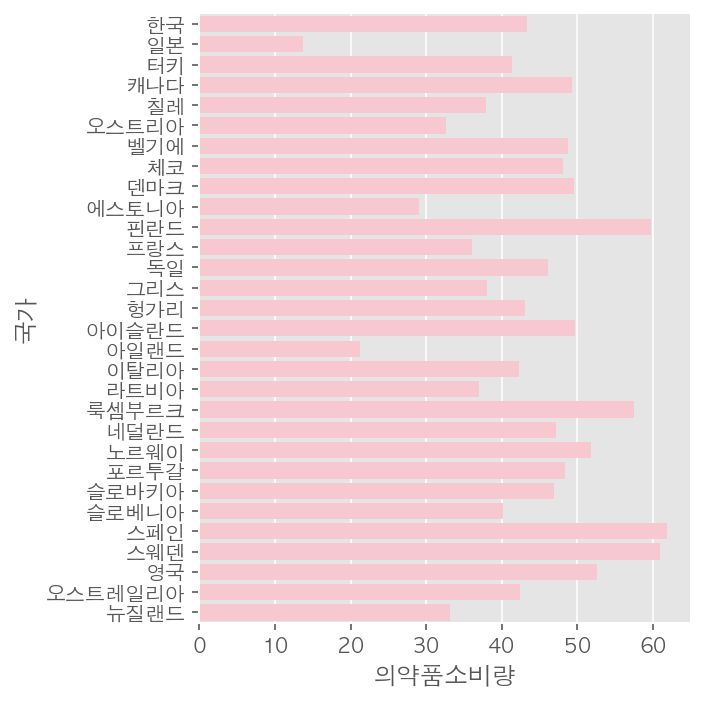

In [34]:
# 국가별 의약품 소비량

sns.catplot(data=df, x='의약품소비량', y='국가', kind='bar', ci=None, color="Pink")

일본의 의약품 판매량이 OECD국가에서 큰 반면 소비량의 경우 적었습니다. 

<AxesSubplot:xlabel='연도', ylabel='의약품판매량'>

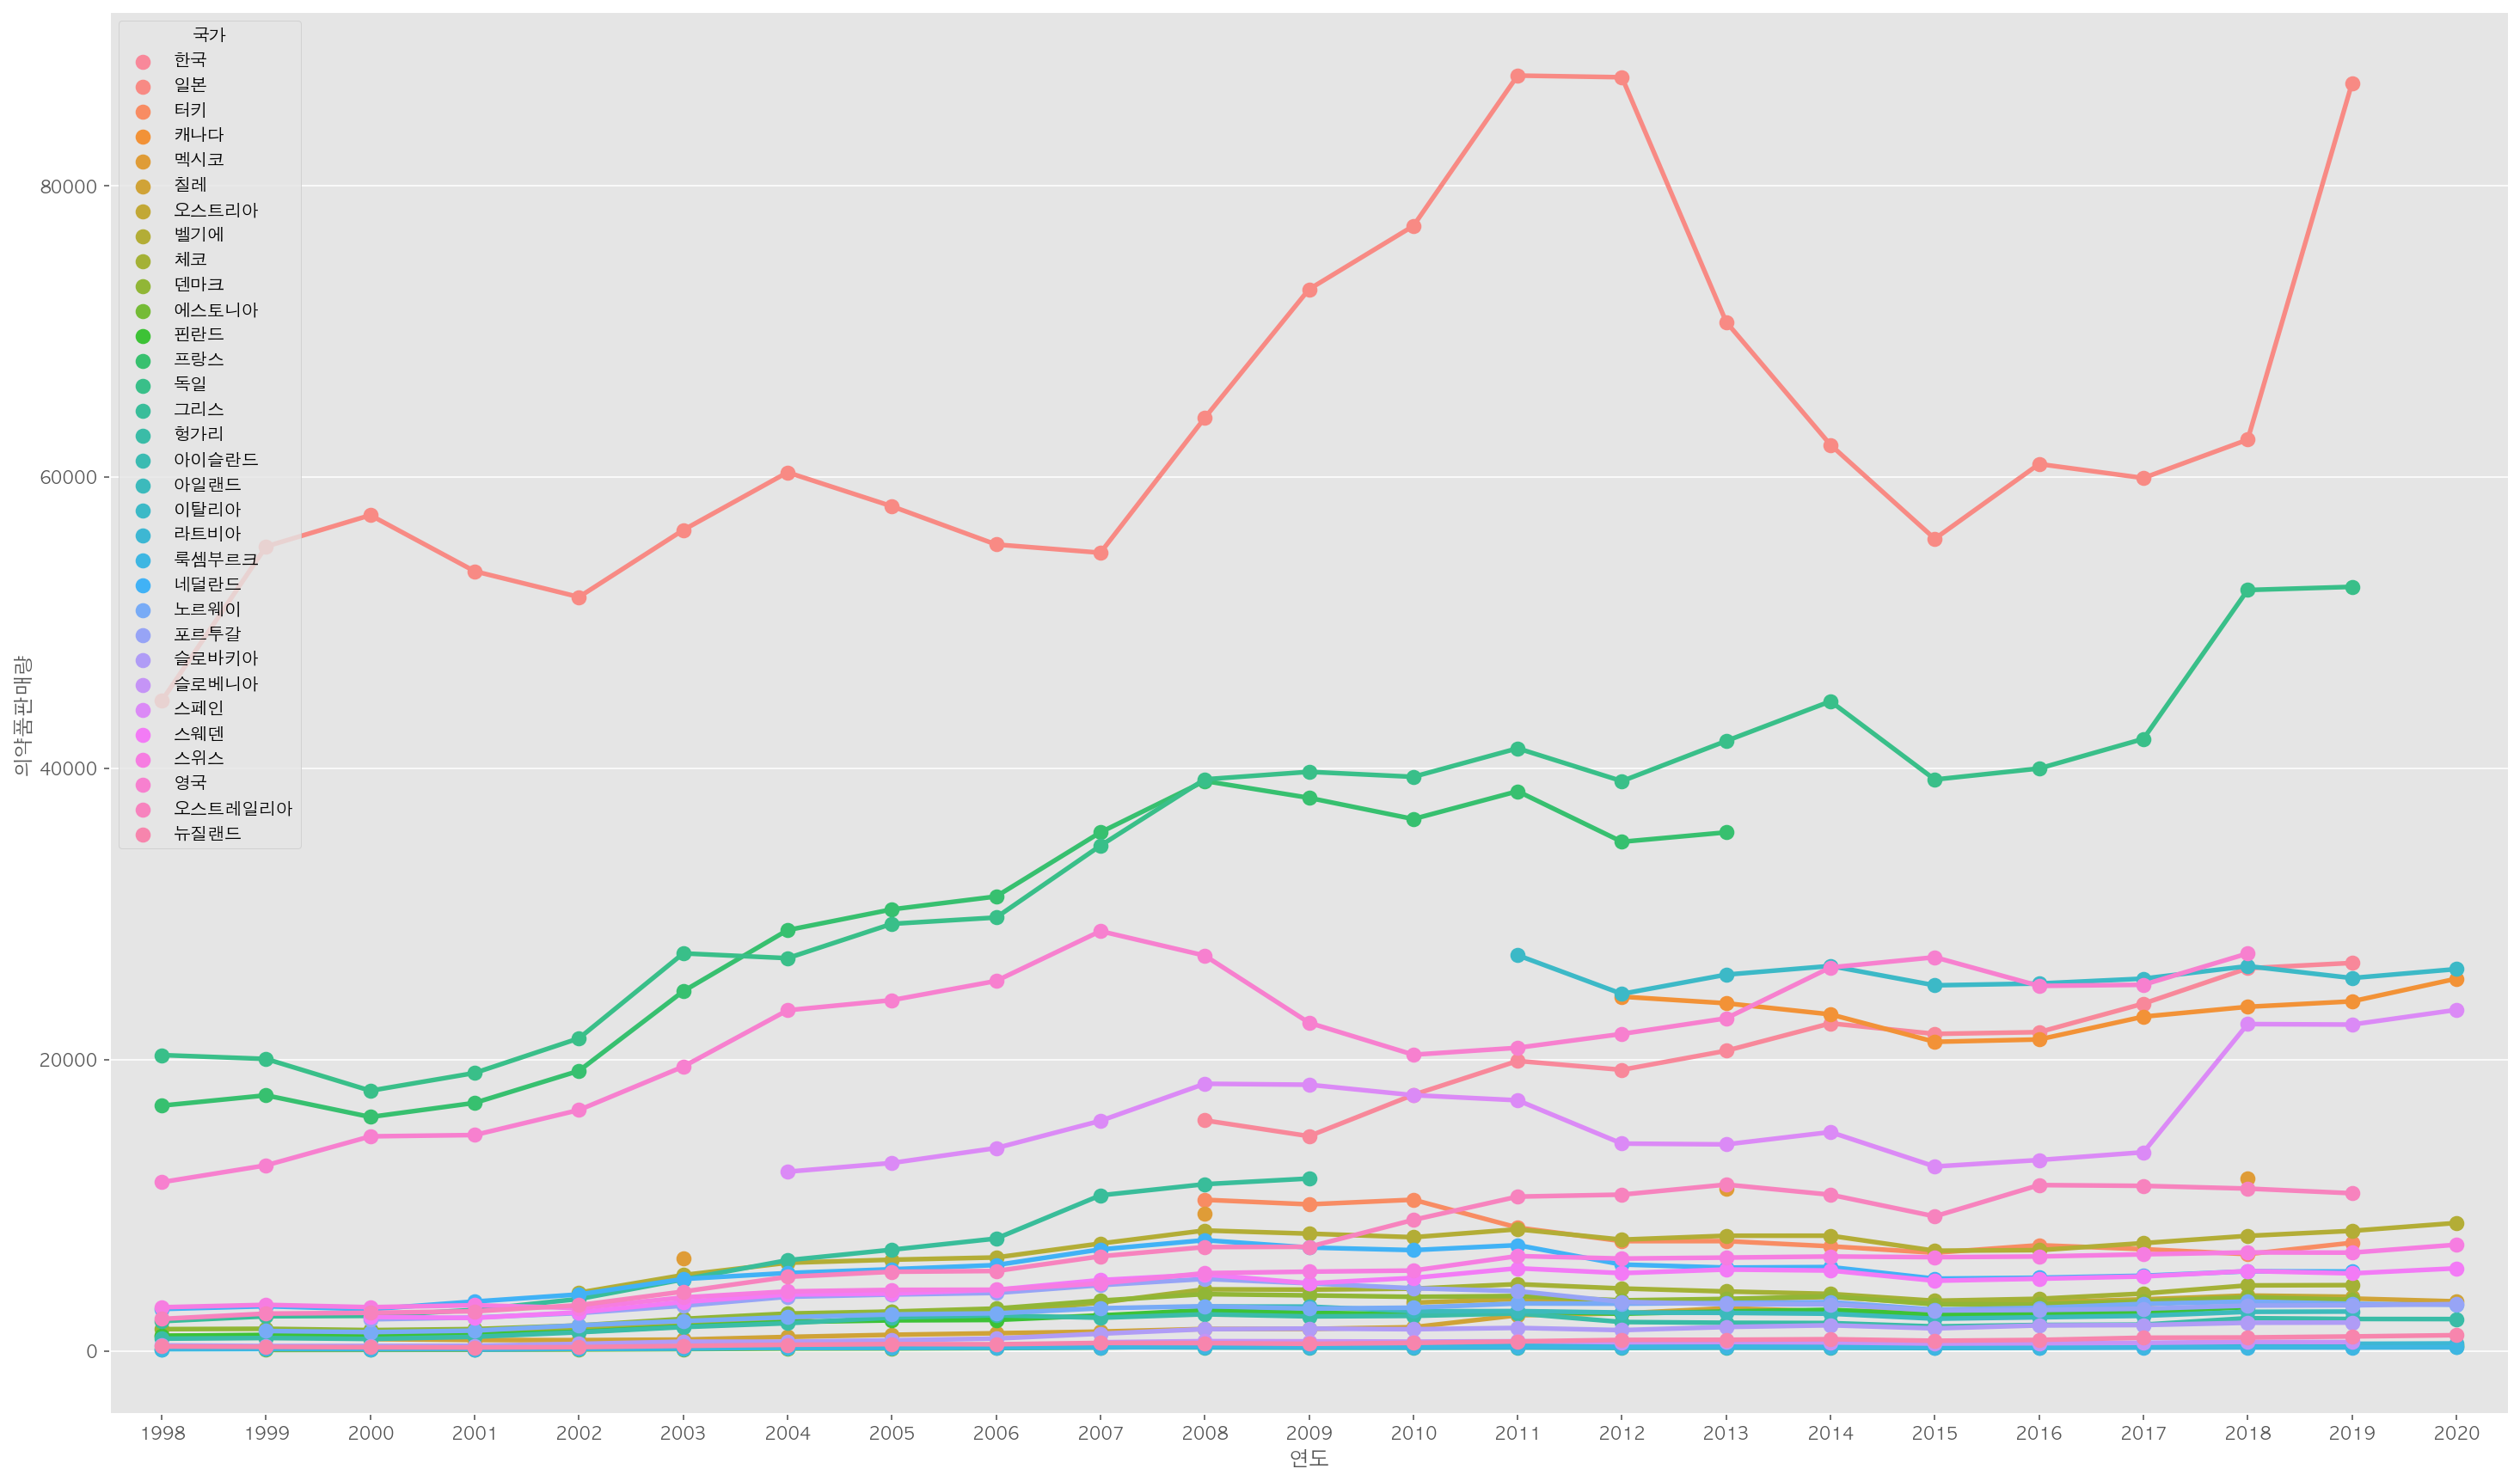

In [36]:
# 연간 국가별 의약판매량 
plt.figure(figsize=(25,15))
sns.pointplot(data=df_sale, x='연도', y='의약품판매량', hue='국가', ci=None)

<AxesSubplot:xlabel='연도', ylabel='의약품소비량'>

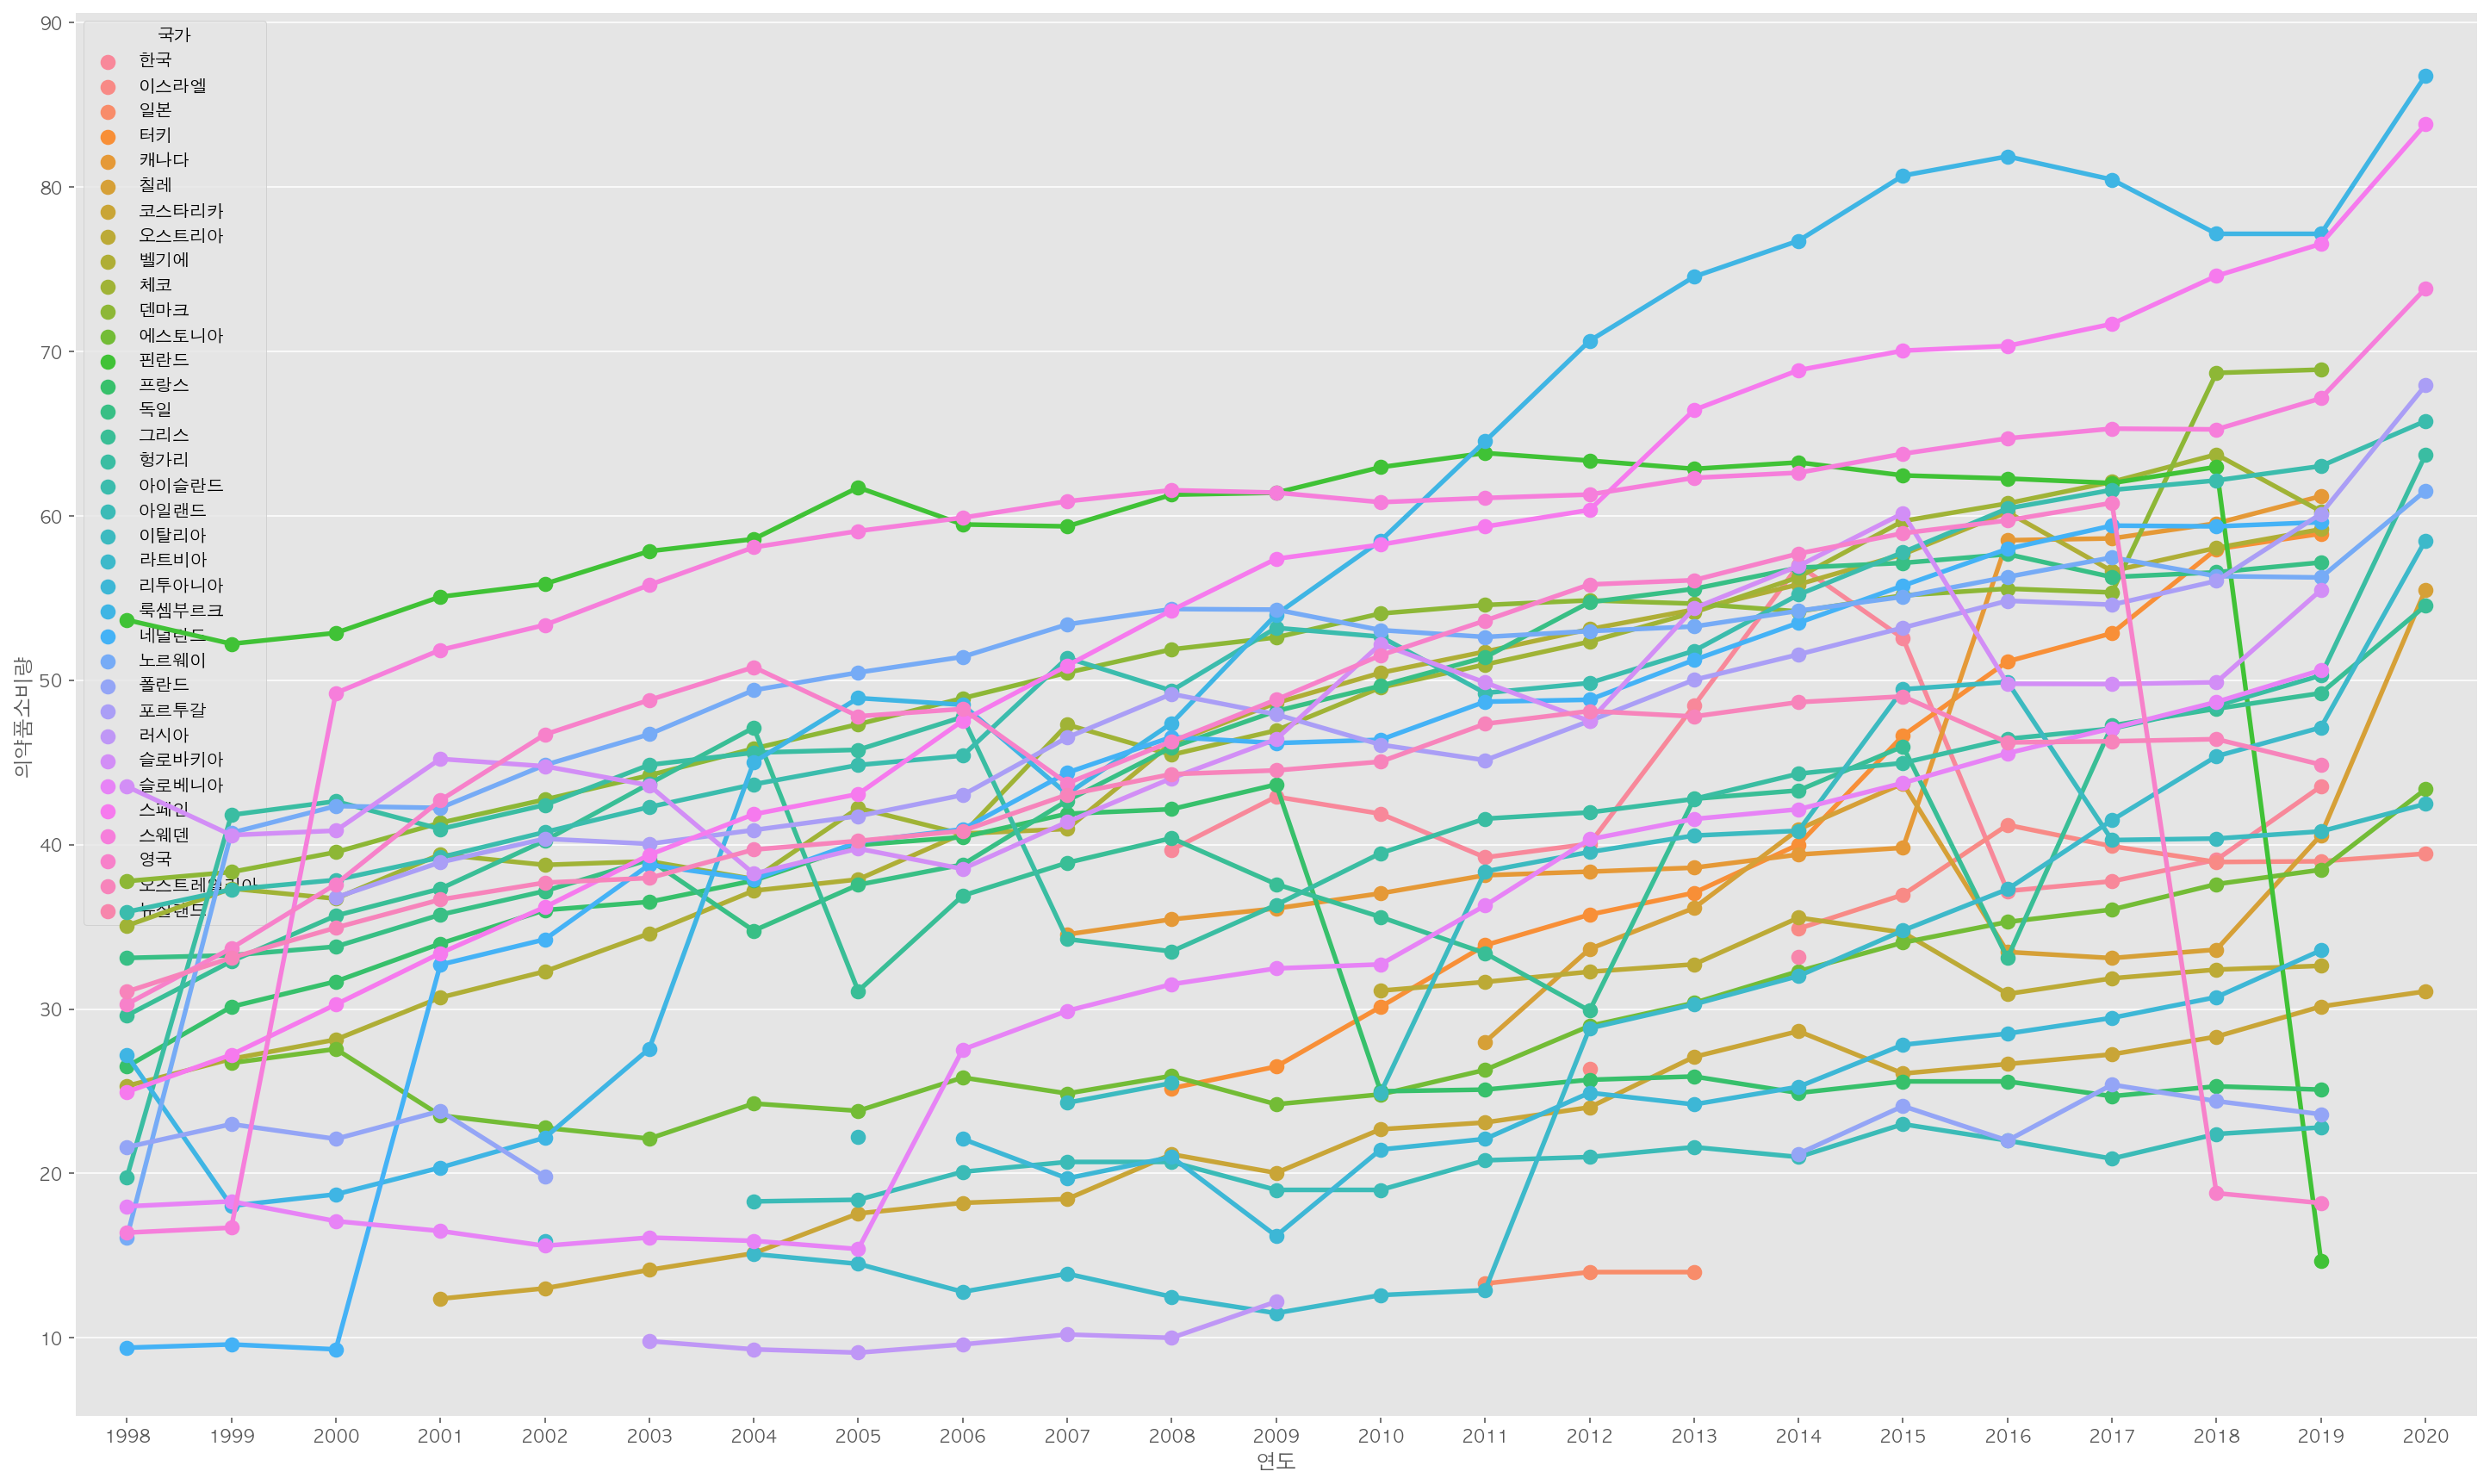

In [38]:
# 연간 국가별 의약소비량 
plt.figure(figsize=(25,15))
sns.pointplot(data=df_consume, x='연도', y='의약품소비량', hue='국가', ci=None)

일본이 연간 국가별 의약 판매량에서 가장 높았으며 2012년에 감소하였다가 18년을 기점으로 증가하얐습니다.

##### 기초 기술 통계

In [17]:
# df_sale(의약품 판매량) 기술통계량
df_sale.describe()

연도        의약품판매량
count   584.000000    584.000000
mean   2009.626712   9300.094178
std       6.258664  14552.475595
min    1998.000000     60.700000
25%    2004.000000   1066.775000
50%    2010.000000   3267.350000
75%    2015.000000   9269.500000
max    2020.000000  87553.300000

In [18]:
# df_consume(의약품 소비량) 기술통계량
df_consume.describe()

연도       의약품소비량
count  5351.000000  5351.000000
mean   2010.220146    45.038535
std       6.170849    60.370413
min    1998.000000     0.000000
25%    2005.000000     6.900000
50%    2011.000000    24.900000
75%    2015.000000    56.600000
max    2020.000000   471.600000

##### 결론 및 한계

- 1998년에서 2000년 초반까지 아시아국가의 의약품 판매 및 소비 데이터가 결측치로 처리되어 있었습니다. 한국은 2008년부터 의약품 소비량 및 판매액 통계를 생산하여 OECD에 제출한 것으로 보아 그 시기에 다른 아시아 국가들도 통계를 집계하지 않아 결측치가 발생한 것으로 예상 할 수 있 수 있습니다. 이로 인해 2000년 초반까지의 결과는 아시아를 제외한 국가들의 통계로 볼 수 있습니다.